# Training example TPV 13-3D

TPV 13-3D is a benchmark exercise that is designed to test if computer codes that simulate earthquake dynamic rupture are working as intended [(Harris et al., SRL 2018)](https://pubs.geoscienceworld.org/ssa/srl/article/89/3/1146/530061/A-Suite-of-Exercises-for-Verifying-Dynamic). It was designed by the [SCEC/USGS Spontaneous Rupture Code Verification Project](https://strike.scec.org/cvws/) and features:

* spontaneous rupture on a 2D planar 60-degree dipping normal fault  
* homogeneous half-space: $V_p=5716\,m/s, V_s=3300\,m/s, \rho=2700\,kg/m^3$
* non-associative Drucker-Prager plasticity with yielding in shear 
* linear-slip weakening (LSW) friction 
* initial stress conditions are depth-dependent and specified everywhere throughout the entire model volume
* prescribed nucleation zone, square, 3 x 3 km in size, locally lower static coefficient of friction
* strongly supershear rupture conditions

![](tpv13.jpg)

[Detailed benchmark description (SCEC)](https://strike.scec.org/cvws/tpv12_13docs.html).

Note that for this training we slightly reduced two material constants, the bulk friction and the bulk cohesion, to increase the effects of off-fault yielding.

## Mesh generation

We use the open-source software Gmsh ([http://gmsh.info](http://gmsh.info)) for mesh generation. The following steps are required:

* create a half-space box-shaped domain (box)
* create a 60° dipping rectangular fault plane
* ensure that the mesh explicitly accounts for the nucleation patch at the hypocenter (why? see [Pelties et al., 2014](https://gmd.copernicus.org/articles/7/847/2014/) and [Galis et al., 2015](https://academic.oup.com/gji/article/200/2/890/609776))
* set all required boundary conditions

Gmsh comes with its own scripting language, and provides a [manual](http://gmsh.info/doc/texinfo/gmsh.html) and [tutorial examples](http://gmsh.info/doc/texinfo/gmsh.html#Tutorial). The first step is to build a geometrical (CAD) model, which is then used by the automatic mesh generator.
We use the gmsh script tpv13_training.geo to generate the 3D unstructured tetrahedral mesh in the next step.

In [1]:
!gmsh -3 ../../tpv13/tpv13_training.geo -setnumber dip 60

Info    : Running 'gmsh -3 ../../tpv13/tpv13_training.geo -setnumber dip 60' [Gmsh 4.11.1, 1 node, max. 1 thread]
Info    : Started on Mon Jan 20 20:36:36 2025
Info    : Reading '../../tpv13/tpv13_training.geo'...
Info    : Done reading '../../tpv13/tpv13_training.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 25 (Line)
Info    : [ 10%] Meshing curve 26 (Line)
Info    : [ 10%] Meshing curve 27 (Line)
Info    : [ 20%] Meshing curve 28 (Line)
Info    : [ 20%] Meshing curve 29 (Line)
Info    : [ 30%] Meshing curve 30 (Line)
Info    : [ 30%] Meshing curve 31 (Line)
Info    : [ 40%] Meshing curve 32 (Line)
Info    : [ 40%] Meshing curve 33 (Line)
Info    : [ 50%] Meshing curve 34 (Line)
Info    : [ 50%] Meshing curve 35 (Line)
Info    : [ 60%] Meshing curve 36 (Line)
Info    : [ 60%] Meshing curve 37 (Line)
Info    : [ 70%] Meshing curve 38 (Line)
Info    : [ 70%] Meshing curve 39 (Line)
Info    : [ 80%] Meshing curve 40 (Line)
Info    : [ 80%] Meshing curve 41 (Line)
Info    :

You should now have a file called `tpv13_training.msh`.
In the next step, we translate this file into the efficient HDF5 format, which is going to be read in by SeisSol. HDF5 stands for the Hierarchical Data Format version 5, and is an open-source file format that supports large, complex, heterogeneous data. HDF5 uses a "file directory" like structure that allows you to organize data within the file in many different structured ways, as you might do with files on your computer, and is built for fast I/O processing and storage.

We use our tool pumgen for mesh generation for SeisSol, which is [open-source software](  https://github.com/SeisSol/PUMGen), see also [SeisSol's documentation]( https://seissol.readthedocs.io/en/latest/meshing-with-pumgen.html). However, here **we already created the final mesh file based on the `tpv13_training.msh` for you** sepcifically the file `tpv13_training.puml.h5`.
While the .h5 file is read by SeisSol, another file `tpv13_training.xdmf` could be used to visualize the mesh, as in the following.

On you local machine (not the Gateway) you could either load the .xdmf mesh file into Paraview (see [Visualization with Paraview](#Visualization-with-Paraview) below) or after installing the python modules `vtk` and `pyvista`, visualize the mesh locally using the code snippet below. You would see that the mesh is refined close to the fault.

```
import vtk
import pyvista as pv

reader = vtk.vtkXdmfReader()
reader.SetFileName('tpv13_training.xdmf')
reader.Update()
mesh = pv.wrap(reader.GetOutput())
pv.plot(mesh, cmap='BuGn', background='white', show_edges=True, jupyter_backend='panel')
```

### Exercises
* Inspect the `tpv13_training.geo` file and try to understand the meshing script. Consult the [Gmsh documentation](https://gmsh.info/doc/texinfo/gmsh.html) about the BooleanFragments operation (which may not be intuitive but is a powerful operation gmsh provides).

Notes:
* The final meshing step would involve [PUMGen](https://github.com/SeisSol/PUMGen), which is not yet available in this current setup. Thus we created the readily available final mesh for you separately. 
* A finer mesh can be created by changing the `h_fault` parameter. Do not change the .geo file but use the [`-setnumber PARAMETER VALUE`](https://gmsh.info/doc/texinfo/gmsh.html#Command_002dline-options) command line argument of above *gmsh* command. Try, for example, to mesh the nucleation patch with 300 m and the remaining fault with 600 m element edge length.
* Change the dip of the fault by changing the dip parameter.

## Run SeisSol for a 3D dynamic rupture earthquake scenario (with off-fault plastic deformation) using the SeisSol App in the Quakeworx Gateway

We start SeisSol using the provided parameter file.

**Please go to the [Quakeworx Gateway](https://qwx1.onescienceway.com) now**, select the SeisSol App, upload the required files, and submit the job.

While SeisSol is running, you might want to checkout the [documentation of the input files](https://seissol.readthedocs.io/en/latest/parameter-file.html).

## Visualization

We now visualize the fault output generated by SeisSol.
Check out the [documentation](https://seissol.readthedocs.io/en/latest/fault-output.html#outputmask) for an explanation of which output field each abbreviation means.

On your local laptop, you could visualize the results interactively as follows:

```
from ipywidgets import interact

reader = vtk.vtkXdmfReader()
reader.SetFileName('output/tpv13-fault.xdmf')
reader.Update()
cd = reader.GetOutput().GetCellData()
variables = [cd.GetArrayName(i) for i in range(cd.GetNumberOfArrays())]

@interact(t=(0.0, 8.0, 1.0), var=variables)
def plot(t=0.0, var='SRd'):
    reader.UpdateTimeStep(t)
    mesh = pv.wrap(reader.GetOutput())
    plotter = pv.Plotter(notebook=True)
    plotter.set_background('white')
    #fix color range for rupture speed
    clim_arg = {"clim":(0, 6000)} if var=='Vr' else {}
    plotter.add_mesh(mesh, cmap='Blues', scalars=var, **clim_arg)
    plotter.view_xz()
    plotter.show(jupyter_backend='panel')
    plotter.close()
```

The above code snippet for visualization is based on ```pyvista``` and ```ipywidgets```, whose rendoring is not well supported inside the container. We show a simpler way of quick visualization of the results. It also comes with fewer non-standard python3 dependencies.

In [2]:
!pip install seissolxdmf
import sys
sys.path.append("/home/qwxdev/.local/lib/python3.12/site-packages")

Defaulting to user installation because normal site-packages is not writeable


In [3]:
import numpy as np
from matplotlib import pyplot as plt

import seissolxdmf as seisx
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.colors as mcolors

# Rupture speed analysis

Here, we analyze the [fault output](https://seissol.readthedocs.io/en/latest/fault-output.html) of SeisSol.

We have to set the path to the simulation outputs, which depends on the name you chose in the Gateway.

**Please use your job name here.**

In [4]:
# Asssuming you job name was "SeisSol_TPV13"
path = "SeisSol_TPV13"

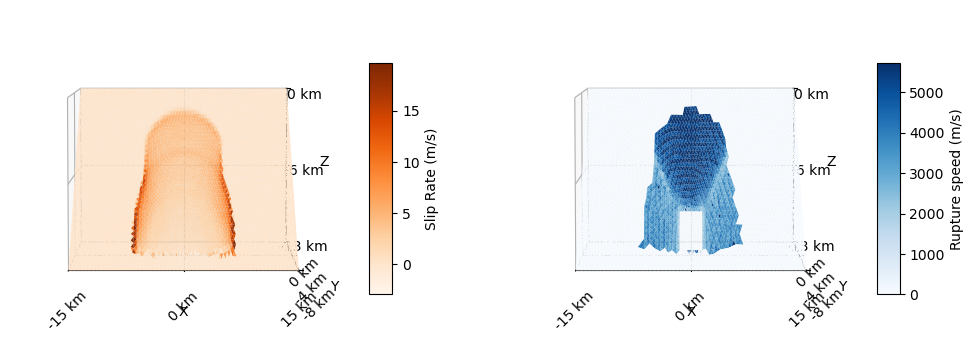

In [5]:
# Load data
xdmfFilename = "../../../{}/outputs/tpv13-fault.xdmf".format(path)
sx = seisx.seissolxdmf(xdmfFilename)
ndt = sx.ReadNdt() - 1
xyz = sx.ReadGeometry()
connect = sx.ReadConnect()
ndt = 2
sRate = sx.ReadData('SRd', ndt)
damage = sx.ReadData('Vr', ndt)

# Define the colormap ranges
sRate_vmin, sRate_vmax = np.min(sRate), np.max(sRate)
sRate_norm = mcolors.Normalize(vmin=sRate_vmin, vmax=sRate_vmax)

damage_vmin, damage_vmax = 0, 5714
damage_norm = mcolors.Normalize(vmin=damage_vmin, vmax=damage_vmax)

# Extract vertices for each triangular face in the mesh
triangles = [xyz[connect[i]] for i in range(connect.shape[0])]

# Prepare data for the triangles
verts = [tri for tri in triangles]
sRate_colors = [plt.cm.Oranges(sRate_norm(np.mean(sRate[i]))) for i in range(len(verts))]
damage_colors = [plt.cm.Blues(damage_norm(np.mean(damage[i]))) for i in range(len(verts))]

# Create subplots
fig = plt.figure(figsize=(12, 6))

x_ticks = np.linspace(np.min(xyz[:, 0]), np.max(xyz[:, 0]), 3)
y_ticks = np.linspace(np.min(xyz[:, 1]), np.max(xyz[:, 1]), 3)
z_ticks = np.linspace(np.min(xyz[:, 2]), np.max(xyz[:, 2]), 3)

# First subplot: Slip Rate
ax1 = fig.add_subplot(121, projection='3d')
sRate_collection = Poly3DCollection(verts, alpha=1.0, facecolor=sRate_colors)
ax1.add_collection3d(sRate_collection)
ax1.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax1.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax1.set_zlim(np.min(xyz[:, 2]), np.max(xyz[:, 2]))
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.set_xticks(x_ticks)
ax1.set_yticks(y_ticks)
ax1.set_zticks(z_ticks)
ax1.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax1.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax1.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])

sm1 = plt.cm.ScalarMappable(cmap='Oranges', norm=sRate_norm)
sm1.set_array([])
cbar1 = plt.colorbar(sm1, ax=ax1, shrink=0.5, aspect=10)
cbar1.set_label('Slip Rate (m/s)')

# Second subplot: Damage
ax2 = fig.add_subplot(122, projection='3d')
damage_collection = Poly3DCollection(verts, alpha=1.0, facecolor=damage_colors)
ax2.add_collection3d(damage_collection)
ax2.set_xlim(np.min(xyz[:, 0]), np.max(xyz[:, 0]))
ax2.set_ylim(np.min(xyz[:, 1]), np.max(xyz[:, 1]))
ax2.set_zlim(np.min(xyz[:, 2]), np.max(xyz[:, 2]))
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_zlabel('Z')
ax2.set_xticks(x_ticks)
ax2.set_yticks(y_ticks)
ax2.set_zticks(z_ticks)
ax2.set_xticklabels([f"{tick/1000:.0f} km" for tick in x_ticks], rotation=45)
ax2.set_yticklabels([f"{tick/1000:.0f} km" for tick in y_ticks], rotation=45)
ax2.set_zticklabels([f"{tick/1000:.0f} km" for tick in z_ticks])
sm2 = plt.cm.ScalarMappable(cmap='Blues', norm=damage_norm)
sm2.set_array([])
cbar2 = plt.colorbar(sm2, ax=ax2, shrink=0.5, aspect=10)
cbar2.set_label('Rupture speed (m/s)')

# Adjust view angles
ax1.view_init(elev=5, azim=270)
ax2.view_init(elev=5, azim=270)

#plt.tight_layout()
plt.show()

### Exercises

Change the variables plotted by choosing different fault output parameters from the [documentation](https://seissol.readthedocs.io/en/latest/fault-output.html).

Find the correct abbreviations and adapt the lines

```
sRate = sx.ReadData('SRd', ndt)
damage = sx.ReadData('Vr', ndt)
...
cbar1.set_label('Slip Rate (m/s)')
...
cbar2.set_label('Rupture speed (m/s)')
```

# Ground deformation exercise
Now we visualize the subsidence and uplift of the earthquake dynamic rupture scenario.

In [6]:
def plot_displacement(xdmfFilename,timestep):
    
    sx = seisx.seissolxdmf(xdmfFilename) # initiate class
    xyz = sx.ReadGeometry() # load geometry array as a numpy array of shape
    connect = sx.ReadConnect() # load connectivity array as a numpy array of shape
    U = sx.ReadData("u3", timestep) # u3 is the vertical displacement
    print(min(U), max(U))
    
    x, y = xyz[:,0], xyz[:,1]
    plt.tripcolor(x, y, connect, facecolors=U, cmap="seismic", rasterized=True, vmin=-10, vmax=10)
    plt.xlabel("Easting")
    plt.ylabel("Northing")
    cbar = plt.colorbar(orientation="horizontal", label="Displacement [m]")

-10.284283942058718 3.1366775346762608


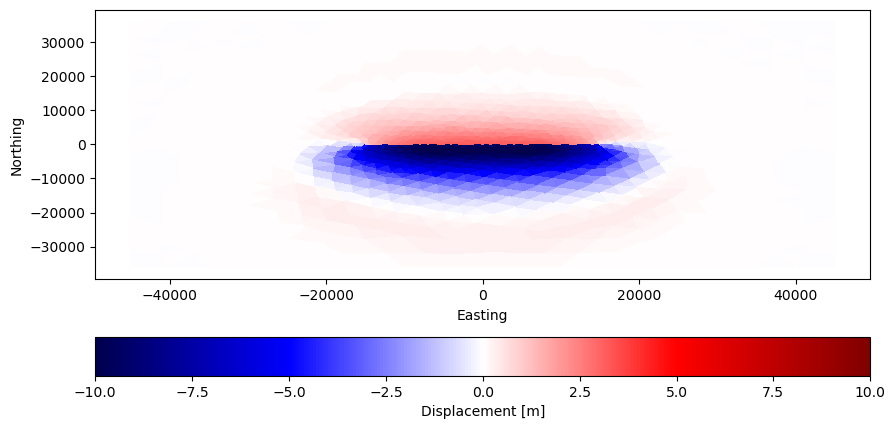

In [7]:
xdmfFilename = "../../../{}/outputs/tpv13-surface.xdmf".format(path)

fig = plt.figure()
fig.set_size_inches(10, 5)
ax1 = plt.gca()
time = 4 # time step
plot_displacement(xdmfFilename,time)

### Exercise

* Plot the coseismic displacement at earlier times and observe its spatio-temporal evolution.

# Initial stress and fault strength

The loading in tpv13 is defined as a stress tensor, which is converted into fault tractions by SeisSol.
In the next cell, we compute analytically the normal and shear tractions, and compute the relative prestress ratio, a key parameter for rupture dynamics, characterizing the initial stress.
By modifying params with the nucleation static friction (mu_s=0.54), verify that this area is critically stressed (R>1).

In [8]:
import sympy as sp
import numpy as np

# Define symbolic variables
s3_to_s1, sigma_max, dip, mu_s, mu_d = sp.symbols("s3_to_s1 sigma_max dip mu_s mu_d")

# stress tensor
stress = sp.diag((1 + s3_to_s1) * sigma_max / 2, s3_to_s1 * sigma_max, sigma_max)
# normal and along dip unit vectors
u_n = sp.Matrix([0, -sp.sin(dip), sp.cos(dip)])
udip = sp.Matrix([0, sp.cos(dip), sp.sin(dip)])

# tractions
traction = stress * u_n

sigma_n = traction.dot(u_n)
print("sigma_n:", sigma_n)
sigma_d = traction.dot(udip)
print("sigma_d:", sigma_d)

R = (sigma_d - mu_d * sigma_n) / ((mu_s - mu_d) * sigma_n)
print("relative prestress ratio R:", R)

params = {"dip": 60 * np.pi / 180, "s3_to_s1": 0.3495, "mu_s": 0.7, "mu_d": 0.1}
print(
    f"relative prestress ration R evaluated with {params}:",
    R.subs(params),
)

print("sigma_n:", sigma_n.subs(params))
print("sigma_d:", sigma_d.subs(params))

sigma_n: s3_to_s1*sigma_max*sin(dip)**2 + sigma_max*cos(dip)**2
sigma_d: -s3_to_s1*sigma_max*sin(dip)*cos(dip) + sigma_max*sin(dip)*cos(dip)
relative prestress ratio R: (-mu_d*(s3_to_s1*sigma_max*sin(dip)**2 + sigma_max*cos(dip)**2) - s3_to_s1*sigma_max*sin(dip)*cos(dip) + sigma_max*sin(dip)*cos(dip))/((-mu_d + mu_s)*(s3_to_s1*sigma_max*sin(dip)**2 + sigma_max*cos(dip)**2))
relative prestress ration R evaluated with {'dip': 1.0471975511965976, 's3_to_s1': 0.3495, 'mu_s': 0.7, 'mu_d': 0.1}: 0.750019567426210
sigma_n: 0.512125*sigma_max
sigma_d: 0.281674762580889*sigma_max


## Visualization with Paraview

You can also visualize the SeisSol output in Paraview on your local machine.

To visualize the copied SeisSol output, open your Paraview and follow these steps: 

* Click on 1) in the upper left corner
* Choose the xdmf file you want to open and click *ok*
* Choose *XDMF Reader* and click the *ok* button
* The output file will appear in the left bar below *Pipeline Browser*. 
Further down, in *Properties*, the *Apply-button* 2) should have turned green. Click on that button to read in the data.
* With 3) you can choose the property you want to display. If you choose *ASL*, the fault slip will be shown.
* With 4) you can switch to the last timestep. With the arrows you can switch back and forth, or you can choose a specific timestep by typing a *time*. 
* 5) adjusts the colorscale automatically to the data range. 
* With 6) you can change the properties of your color scale (i.e. color, range, log scale). 

![](paraview.jpg)


# Local-time stepping exercises

One of the key features of SeisSol is an efficient local-time stepping scheme, which clusters elements with similar time steps. This method pays off for applications featuring big differences in element sizes, caused by geometric complexity ([Ulrich et al., 2021](https://eartharxiv.org/repository/view/39/)) and/or multi-physics such as fully coupled seismic-acoustic-tsunami simulations ([Krenz et al., 2021](https://arxiv.org/abs/2107.06640)) or poroelastic wave propagation ([Wolf et al., 2021](https://arxiv.org/abs/2108.10565)).  

A time-step cluster $c \in \mathbb{N}_0$ has the time-step
$$\Delta t_c = r^c \Delta t_{\text{min}},$$
where the rate $r \in \mathbb{N}$. In the parameter file the rate $r$ can be set with the *ClusteredLTS* parameter.

* Run SeisSol once with rate-2 local time-stepping (LTS) and once with global time-stepping (GTS).
* In the log, look for "Elapsed time (via clock_gettime)" for both LTS and GTS.
* Compute the speed-up and compare it to the theoretical speed-up due to LTS.

*Hint:* You may reduce the *EndTime* parameter for this exercise.